<a href="https://colab.research.google.com/github/jalkestrup/fastai_course/blob/main/04_NLP/patent_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP, Lesson 4
## Patent Kaggle Competition

Install required packages> Either by pip install on colab or just running local mamba env

In [9]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
  colab_flag = True
else:
  colab_flag = False

if colab_flag == True:
   print("Running in Colab...")
   #Install Kaggle API
   ! pip install -q kaggle
   #Install Huggingface Datasets lib
   ! pip install -q datasets
   #Install Huggingface transformers & the sentencepiece
   ! pip install -q transformers[sentencepiece,torch]
   print("...Installed required dependencies")
else:
   print("NOT in Colab")

Running in Colab


If running on Golab, load Kaggle API secret from google drive folder by authenticating with google drive

In [10]:
if colab_flag == True:
  import json
  from google.colab import drive
  drive.mount('/content/drive/')

  # Set the file path
  file_path = '/content/drive/MyDrive/dtu/04_NLP/kaggle_api.json'

  # Check if the file exists
  if os.path.exists(file_path):
      # Load the JSON file
      with open(file_path) as f:
          creds = json.load(f)
  else:
      # Handle the case when the file does not exist
      creds = None  # or any other appropriate action you want to take
      print('Error: File not found, Credentials NOT set')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
#Fill in API information from Kaggle. Delete before pushing to git.
#In the form of '{"username:":"X", "key":"Y"}'
#creds = ''

In [11]:
#using `pathlib.Path to work with paths in Python`
from pathlib import Path
#Set path for the US Patent competition
path = Path('us-patent-phrase-to-phrase-matching')

In [12]:
if path.exists():
  print('Data folder exists')
else:
  print('Data not detected, starting download')
  #Setup of kaggle credentials to use the API for downloading dataset
  cred_path = Path('~/.kaggle/kaggle.json').expanduser()
  if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)
  import zipfile,kaggle
  #Download data
  kaggle.api.competition_download_cli(str(path))
  #Unzip at path
  zipfile.ZipFile(f'{path}.zip').extractall(path)

#Verifying the the path, expects: sample_submission.csv  test.csv  train.csv
!ls {path}

Data folder exists
sample_submission.csv  test.csv  train.csv


In [13]:
import pandas as pd

In [14]:
#Load data as DF
df = pd.read_csv(path/'train.csv')
df.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [15]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


To make the input suitable for a transformer model we join the entire input to a single string, and add a "random" delimiter between context, anchor and target so that the model can learn to distinguish seperations.

In [16]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor

In [17]:
df.input.head()


0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

In [18]:
#Convert dataframe to Dataset object
from datasets import Dataset, DatasetDict
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

We can't pass the texts directly into a model. A deep learning model expects numbers as inputs, not English sentences. So we need to do two things:

- Tokenization: Split each text up into words (or actually, as we'll see, into tokens)
- Numericalization: Convert each word (or token) into a number.

In [19]:
model_nm = 'microsoft/deberta-v3-small'

In [20]:
#AutoTokenizer will create a tokenizer appropriate for a given model:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
#Excample of splitting a text into "Tokens"
tokz.tokenize("Howdy my name is Jesper, I'm delighted to be a ornithorhynchus anatinus")


['▁Howdy',
 '▁my',
 '▁name',
 '▁is',
 '▁Jesper',
 ',',
 '▁I',
 "'",
 'm',
 '▁delighted',
 '▁to',
 '▁be',
 '▁a',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus']

Uncommon words will be split into pieces. The start of a new word is represented by ▁:

In [22]:
def tok_func(x):
  return tokz(x['input'])

In [23]:
#To run this quickly in parallel on every row in our dataset, use map:
tok_ds = ds.map(tok_func, batched=True)
#Took 5s to run

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

In [24]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

In [25]:
print(f"Copied underscore, {tokz.vocab['▁of']}")
#Strange error, the underscore that my keyboard output seem to be a different character than that used in the tokz dict
print(f"Underscore from keyboard, {tokz.vocab['_of']}")
#Likely related to this unicode: https://tex.stackexchange.com/questions/429171/package-inputenc-error-unicode-char-u2581-inputenc-not-set-up-for-use
#Turns out that Tokz uses LOWER ONE EIGHTH BLOCK underscore with unicode 2581
#My keyboard underscore outputs LOW LINE w. unicode 005F

Copied underscore, 265


KeyError: ignored

The Transformers library assume that labels are in a column named labels (but they are currently in score), renaming:

In [26]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

# Training the model

In [51]:
#Split our dataset w 25% for validation
#Per default, datasets create the validationset with the name "test"
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

The Patent competition is evaluated on the pearson coefficient. Using the np Corrcoef we write a small function that grabs the coefficient from the 2x2 matrix in which the diagonals are 1.0

Secondly the Transformers expects metrics to be returned as a dict, hence we transform the values.

In [83]:
def corr(x,y):
  return np.corrcoef(x,y)[0][1]


def corr_d(eval_pred):
  return {'pearson': corr(*eval_pred)}

In [73]:
from transformers import TrainingArguments,Trainer
import numpy as np

In [89]:
bs = 128
epochs = 20
lr = 8e-5

args = TrainingArguments(
    'outputs',
    learning_rate=lr,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    fp16=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs,
    weight_decay=0.01,
    logging_strategy='epoch',
    report_to='none')

In [90]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model,
                  args,
                  train_dataset=dds['train'],
                  eval_dataset=dds['test'],
                  tokenizer=tokz,
                  compute_metrics=corr_d)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [91]:
trainer.train();

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Pearson
1,0.058700,0.031142,0.781549
2,0.027900,0.026599,0.809954
3,0.020000,0.026901,0.822486
4,0.014800,0.023087,0.831962
5,0.011400,0.022536,0.835387
6,0.009400,0.020475,0.840828
7,0.007900,0.020247,0.838808
8,0.006800,0.022088,0.838769
9,0.006000,0.021760,0.840798
10,0.005100,0.020800,0.842255


In [92]:
trainer.state.log_history

[{'loss': 0.0587,
  'learning_rate': 3.981308411214954e-05,
  'epoch': 1.0,
  'step': 214},
 {'eval_loss': 0.031142374500632286,
  'eval_pearson': 0.7815493355736935,
  'eval_runtime': 6.0431,
  'eval_samples_per_second': 1508.983,
  'eval_steps_per_second': 5.957,
  'epoch': 1.0,
  'step': 214},
 {'loss': 0.0279,
  'learning_rate': 7.981308411214954e-05,
  'epoch': 2.0,
  'step': 428},
 {'eval_loss': 0.02659924328327179,
  'eval_pearson': 0.8099537464805567,
  'eval_runtime': 3.9564,
  'eval_samples_per_second': 2304.871,
  'eval_steps_per_second': 9.099,
  'epoch': 2.0,
  'step': 428},
 {'loss': 0.02,
  'learning_rate': 7.939796193918374e-05,
  'epoch': 3.0,
  'step': 642},
 {'eval_loss': 0.026901204138994217,
  'eval_pearson': 0.8224857205196572,
  'eval_runtime': 3.1628,
  'eval_samples_per_second': 2883.217,
  'eval_steps_per_second': 11.382,
  'epoch': 3.0,
  'step': 642},
 {'loss': 0.0148,
  'learning_rate': 7.759885004440793e-05,
  'epoch': 4.0,
  'step': 856},
 {'eval_loss': 0

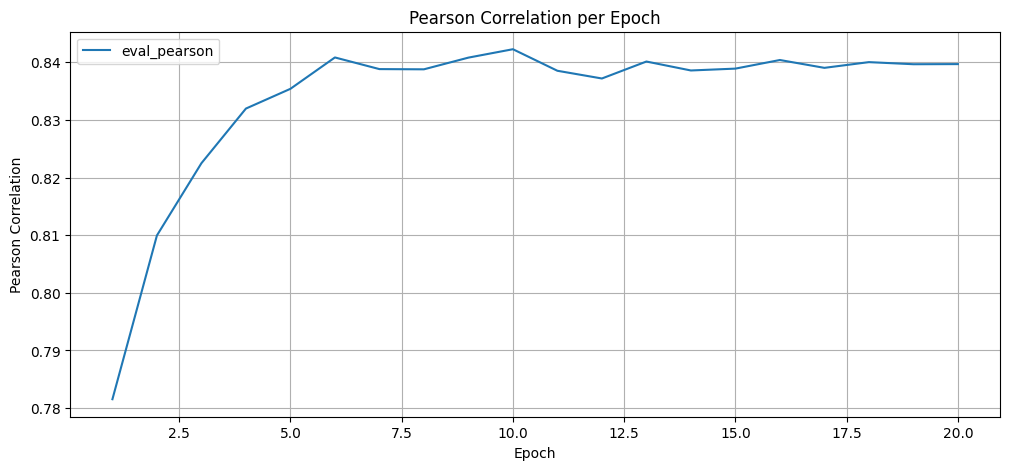

In [93]:
import matplotlib.pyplot as plt

# Get eval_loss and eval_pearson values per epoch from log_history
#eval_loss = []
eval_pearson = []
for log in trainer.state.log_history:
    if 'eval_pearson' in log:
        #eval_loss.append(log['eval_loss'])
        eval_pearson.append(log['eval_pearson'])

# Plotting the losses per epoch
epochs = range(1, len(eval_pearson) + 1)

plt.figure(figsize=(12, 5))
#plt.plot(epochs, eval_loss, label='eval_loss')
plt.plot(epochs, eval_pearson, label='eval_pearson')

plt.title('Pearson Correlation per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Pearson Correlation')
plt.legend()
plt.grid(True)

plt.show()


In [95]:
bs = 128
epochs = 15
lr = 8e-4

args = TrainingArguments(
    'outputs',
    learning_rate=lr,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    fp16=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs,
    weight_decay=0.01,
    logging_strategy='epoch',
    report_to='none')

model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model,
                  args,
                  train_dataset=dds['train'],
                  eval_dataset=dds['test'],
                  tokenizer=tokz,
                  compute_metrics=corr_d)

trainer.train();

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

Epoch,Training Loss,Validation Loss,Pearson
1,0.054700,0.034271,0.737029
2,0.042400,0.056917,0.500121
3,0.059800,0.065539,0.029740
4,0.068100,0.065535,nan
5,0.067800,0.067463,nan
6,0.067800,0.065711,nan
7,0.067700,0.065532,nan
8,0.067600,0.065569,nan
9,0.067500,0.065544,nan
10,0.067400,0.065573,nan


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWa

In [ ]:
# Get eval_loss and eval_pearson values per epoch from log_history
#eval_loss = []
eval_pearson = []
for log in trainer.state.log_history:
    if 'eval_pearson' in log:
        #eval_loss.append(log['eval_loss'])
        eval_pearson.append(log['eval_pearson'])

# Plotting the losses per epoch
epochs = range(1, len(eval_pearson) + 1)

plt.figure(figsize=(12, 5))
#plt.plot(epochs, eval_loss, label='eval_loss')
plt.plot(epochs, eval_pearson, label='eval_pearson')

plt.title('Pearson Correlation per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Pearson Correlation')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
bs = 128
epochs = 20
lr = 8e-3

args = TrainingArguments(
    'outputs',
    learning_rate=lr,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    fp16=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs,
    weight_decay=0.01,
    logging_strategy='epoch',
    report_to='none')

model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model,
                  args,
                  train_dataset=dds['train'],
                  eval_dataset=dds['test'],
                  tokenizer=tokz,
                  compute_metrics=corr_d)

trainer.train();

In [ ]:
# Get eval_loss and eval_pearson values per epoch from log_history
#eval_loss = []
eval_pearson = []
for log in trainer.state.log_history:
    if 'eval_pearson' in log:
        #eval_loss.append(log['eval_loss'])
        eval_pearson.append(log['eval_pearson'])

# Plotting the losses per epoch
epochs = range(1, len(eval_pearson) + 1)

plt.figure(figsize=(12, 5))
#plt.plot(epochs, eval_loss, label='eval_loss')
plt.plot(epochs, eval_pearson, label='eval_pearson')

plt.title('Pearson Correlation per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Pearson Correlation')
plt.legend()
plt.grid(True)

plt.show()